# Importación de librerías

In [1]:
import pandas as pd
import numpy as np
import splitfolders
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


from keras.optimizers import Adam
from keras.layers import Activation, Dense, Dropout, Conv2D, Flatten ,MaxPooling2D
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model


# Verificación de GPU

In [7]:
from tensorflow.test import gpu_device_name
if gpu_device_name():
    print(f'GPU Disponible: {gpu_device_name()}')
else:
    print("No hay GPU disponible, se usara la CPU")
# Originalemente se uso una GPU para el entrenamiento de la red neuronal, pero se cambio a CPU para la ejecucion del programa

No hay GPU disponible, se usara la CPU


# Dividir carpetas en conjuntos de datos (opcional)

In [8]:
# Directorio que contiene tus espectrogramas
input_dir = "C:\Diego\music-genre-classifier\imagenes\gtzan2"
# Directorio de salida donde se guardarán los conjuntos divididos
output_dir = "C:\Diego\music-genre-classifier\imagenes\gtzan_split"

# Dividir los datos en conjuntos de entrenamiento, validación y prueba
# splitfolders.ratio(input_dir, output=output_dir, seed=1337, ratio=(0.7, 0.15, 0.15))

# Preprocesamiento de imágenes con Keras

In [ ]:
# Directorio raíz donde se encuentran las carpetas de las clases
data_dir = 'C:\Diego\music-genre-classifier\imagenes\gtzan2_split'
train_dir = f"{data_dir}/train"
val_dir = f"{data_dir}/val"
test_dir = f"{data_dir}/test"
# Dimensiones de las imágenes
img_width, img_height = 216, 224
# Batch size
batch_size = 64

# Crear generador de datos
datagen = ImageDataGenerator(
    rescale=1./255, 

         # Normalizar los valores de píxeles entre 0 y 1
  )    # Proporción de datos para validación y prueba

# Generador de datos para entrenamiento y validación (incluyendo la división)
train_generator = datagen.flow_from_directory(
    train_dir,                       # Directorio raíz
    target_size=(img_width, img_height),  # Dimensiones de las imágenes
    batch_size=batch_size,          # Tamaño del batch
    class_mode='categorical',       # Modo de clasificación categórica
  shuffle=True
  )              # Usar conjunto de entrenamiento

# Generador de datos para validación
validation_generator = datagen.flow_from_directory(
    val_dir,                       # Directorio raíz
    target_size=(img_width, img_height),  # Dimensiones de las imágenes
    batch_size=batch_size,          # Tamaño del batch
   shuffle=True

    )            # Usar conjunto de validación

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),  # Dimensiones de las imágenes
    batch_size=batch_size, 
      shuffle=False

)

# Creación del modelo de Red Neuronal Convolucional

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(img_width, img_height, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(10))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Entrenamiento del modelo

In [ ]:
# Entrenar el modelo
history = model.fit(train_generator, epochs=10, validation_data=val_dir)

Tras un filtrado de parametros inicial, se realiza una hiperparametrización

In [10]:
def create_model(filters_per_layer, dropout_rate, dense_units, input_shape):
    model = Sequential()
    
    # Add convolutional layers
    for filters in filters_per_layer:
        if model.layers:
            model.add(Conv2D(filters, (3, 3), activation='relu', padding='same'))
        else:
            model.add(Conv2D(filters, (3, 3), activation='relu', padding='same', input_shape=input_shape))
        model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # Flatten the output
    model.add(Flatten())
    
    # Add dense layers
    for units in dense_units:
        model.add(Dense(units, activation='relu'))
        model.add(Dropout(dropout_rate))
    
    # Output layer
    model.add(Dense(10, activation='softmax'))  # Assuming 10 classes for classification
    
    # Compile the model
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Example usage in your model_trainer function
def model_trainer():
    filters_per_layer = [[32, 64, 128, 128], [32, 64, 64, 128], [32, 64, 128, 256]]
    dropout_rate = [0.1, 0.3]
    dense_units = [[1024, 256], [512, 256], [128, 64]]
    best_accuracy = 0
    for filters in filters_per_layer:
        for dropout in dropout_rate:
            for dense in dense_units:
                model = create_model(filters_per_layer=filters, dropout_rate=dropout, dense_units=dense, input_shape=(img_width, img_height, 3))
                print('Training model with filters={}, dropout={}, dense={}'.format(filters, dropout, dense))
                model.fit(train_generator, validation_data=validation_generator, epochs=10, verbose=0)
                accuracy = model.evaluate(test_generator)[1]
                print('Accuracy:', accuracy)
                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    best_model = model

#model = model_trainer()
MODEL_PATH = "/Users/diego/UValencia/TFG/notebook/model/modelo90%.h5"
model = load_model(MODEL_PATH)

def model_trainer():
    filters_per_layer = [[32, 64, 128, 128], [32, 64, 64, 128], [32, 64, 128, 256]]
    dropout_rate = [0.1, 0.3]
    dense_units = [[1024, 256], [512, 256], [128, 64]]
    best_accuracy = 0
    for filters in filters_per_layer:
        for dropout in dropout_rate:
            for dense in dense_units:
                model = create_model(filters_per_layer=filters, dropout_rate=dropout, dense_units=dense, input_shape=(img_width, img_height, 3))
                print('Training model with filters={}, dropout={}, dense={}'.format(filters, dropout, dense))
                model.fit(train_generator, validation_data=validation_generator, epochs=10, verbose=0)
                accuracy = model.evaluate(test_generator)[1]
                print('Accuracy:', accuracy)
                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    best_model = model

#model = model_trainer()
MODEL_PATH = "/Users/diego/UValencia/TFG/notebook/model/modelo90%.h5"
model = load_model(MODEL_PATH)


# Evaluación del modelo

In [ ]:
score = model.evaluate(test_generator,
                        verbose = 1)  

# Assuming model.predict(test_generator) returns the predicted labels
# and test_generator.classes gives the true labels

# Replace these with your actual predicted and true labels
predicted_labels = model.predict(test_generator)
true_labels = test_generator.classes

# Visualización de filtros aprendidos

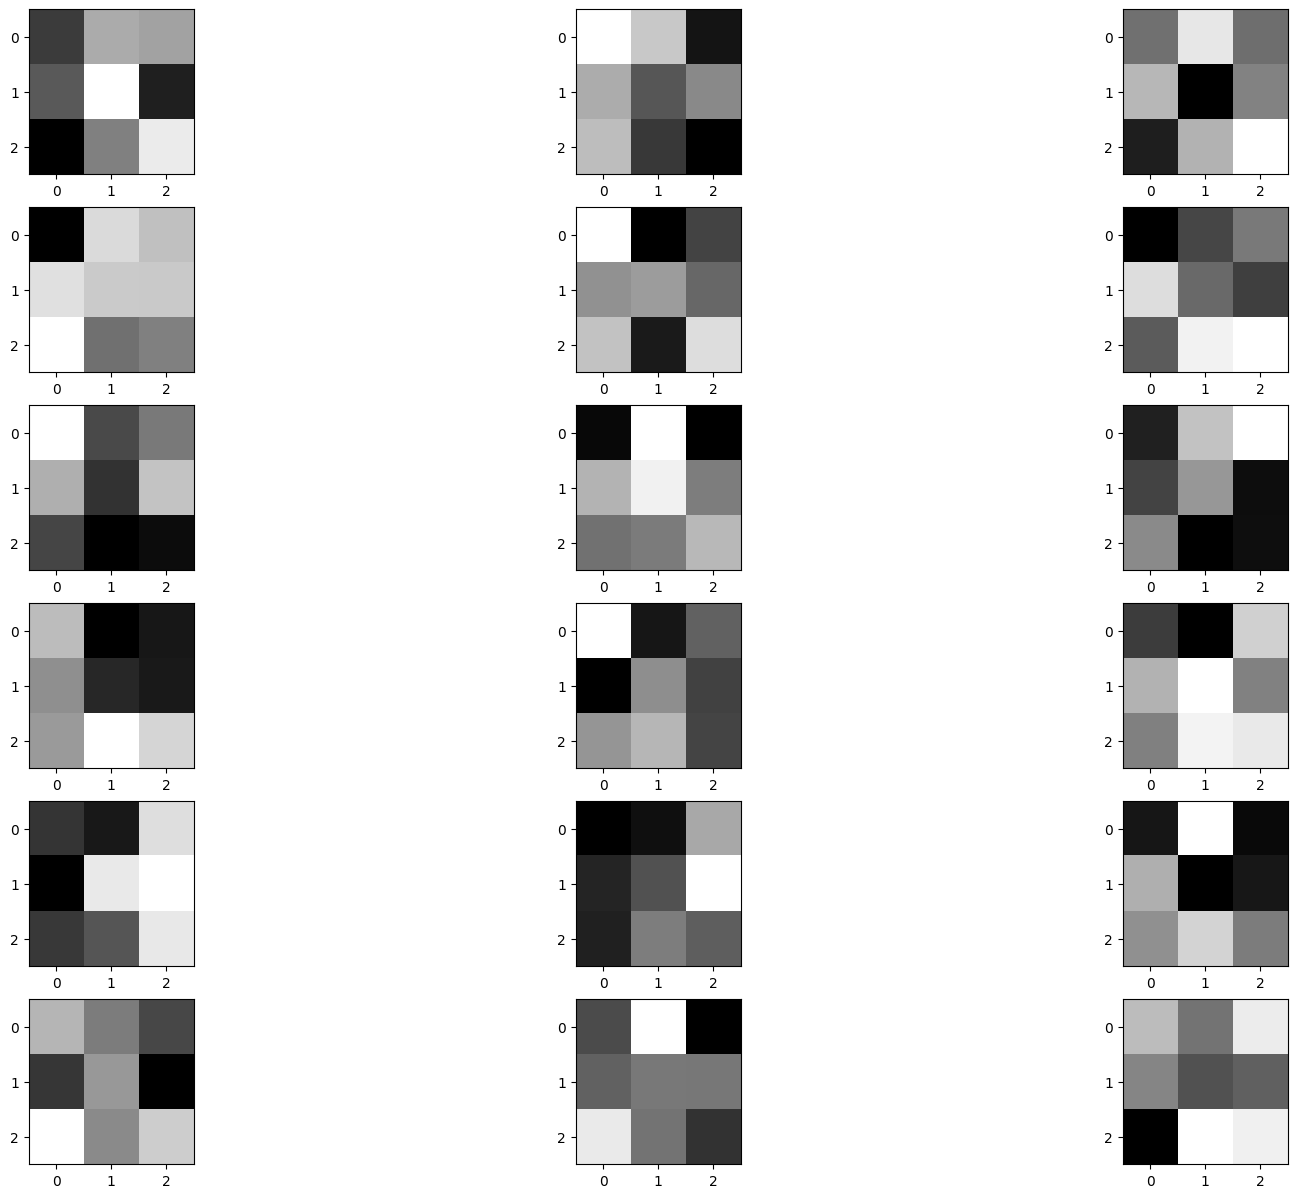

In [14]:
filters, biases = model.layers[0].get_weights()
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

n_filters = 6
ix = 1
fig = plt.figure(figsize=(20,15))
for i in range(n_filters):
    f = filters[:, :, :, i]
    for j in range(3):
        plt.subplot(n_filters, 3, ix)
        plt.imshow(f[:, :, j], cmap='gray')
        ix += 1
plt.show()

# Predicción y tiempo de inferencia

In [ ]:
import time
start_time = time.perf_counter()
preds = model.predict(train_generator[0][0])
elapsed_time = time.perf_counter() - start_time
print(f'Tiempo transcurrido: {elapsed_time} segundos')